In [52]:
import pandas as pd
import numpy as np

from datetime import datetime
from datetime import timedelta

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
to_datetime = lambda d: datetime.strptime(d, '%m/%d/%Y %H:%M')
df = pd.read_csv('takehome_user_engagement.csv')

df['time_stamp'] = df['time_stamp'].astype('datetime64[ns]')

In [3]:
df1 = df.sort_values(by= ['user_id', 'time_stamp'])

In [4]:
#df1['ID'] = df1['time_stamp']
#df1['ID2'] = df1['user_id']

#df2 = df1.set_index(['ID'])
#df2 = df2.drop(columns = ['time_stamp'])
#df = df['time_stamp'].groupby(pd.Grouper(freq='7D')).agg('count')
#df2['visited'] = df2.groupby('user_id')['visited'].transform(lambda v: v.ffill())

df1.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
len(df1['user_id'].unique())

8823

In [6]:
# Create a dictionary that labels each user as adopted or not
seven_days = timedelta(7)
adopted_dict = {}

for user_id in sorted(list(df1['user_id'].unique())):
    
    adopted_user = False
    temp = df1[df1['user_id'] == user_id]
    temp = temp.sort_values('time_stamp')
    
    for row in temp.itertuples():
        if adopted_user == True:
            continue
        #this_time = temp.get_value(row[0], 'time_stamp')
        this_time = temp.at[(row[0], 'time_stamp')]
        if len(temp[(temp['time_stamp'] >= this_time) & (temp['time_stamp'] <= (this_time + seven_days))]) >= 3:
            adopted_user = True
    
    adopted_dict[user_id] = adopted_user

In [78]:
# Load
dfu = pd.read_csv('takehome_users.csv', encoding='latin1')

#remove all users that never logged in
dfu = dfu[pd.notnull(dfu['last_session_creation_time'])]

print(len(df1['user_id'].unique()))
print(len(dfu['object_id'].unique()))

dfa = pd.DataFrame()

dfa['adopted'] = list(adopted_dict.values())
dfa['user_id'] = list(adopted_dict.keys())

8823
8823


In [99]:
df_a = dfa['adopted'].groupby(dfa['adopted']).agg('count')
df_a = pd.DataFrame(df_a)

df_a.columns = ['Noofusers']

da = df_a.reset_index(level=0)
da.columns = ['adopted','Noofusers']

da['adoptedc'] = da.apply(lambda row: 'True' if row['adopted'] == True else 'False', axis=1)

da


,adopted,Noofusers,adoptedc
0,False,7167,False
1,True,1656,True


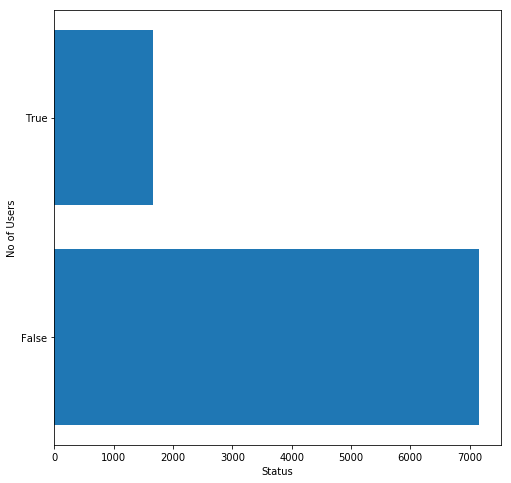

In [101]:
plt.figure(1, figsize=(8, 8))
plt.barh(da['adoptedc'], da['Noofusers'], data=da)
plt.xlabel('Status')
plt.ylabel('No of Users')
plt.show()

#### Feature Engineering
Variables like name, email address and organisational id does not seem to add value to the intended model, hence will be removed. 

However, the feature lasr session creation time indicated the last time the system was used and so will be used to make calculation that can improve the model to be develoed.

In [56]:
#Merge the datasets together

dfu = dfu.merge(dfa, left_on='object_id', right_on='user_id')

#This variables will be dropped because they dont add value
dfu = dfu.drop(columns = ['name', 'email', 'org_id'])

dfu['last_session_creation_time'] =  dfu['last_session_creation_time'].map(lambda a: datetime.utcfromtimestamp(a).strftime('%Y-%m-%d %H:%M:%S'))


In [57]:
#Convert creation time and last session date to datetime
dfu['creation_time'] = pd.to_datetime(dfu['creation_time'] )
dfu['last_session_creation_time'] = pd.to_datetime(dfu['last_session_creation_time'] )

#Most recent session
dfu['totaldays'] = dfu.apply(lambda row: (row["last_session_creation_time"] - row["creation_time"]).days, axis=1)

dfu['invited'] = dfu.apply(lambda row: 1 if row['invited_by_user_id'] >= 0 else 0, axis=1)

dfu['adoptedn'] = dfu.apply(lambda row: 1 if row['adopted'] == True else 0, axis=1)

#dfu = dfu.reset_index(level=0)

dfu = dfu.set_index('object_id')

dfu.head(100)

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_user_id,adopted,user_id,totaldays,invited,adoptedn
object_id,,,,,,,,,,,
1,2014-04-22 03:53:00,GUEST_INVITE,2014-04-22 03:53:30,1,0,10803.0,False,1,0,1,0
2,2013-11-15 03:45:00,ORG_INVITE,2014-03-31 03:45:04,0,0,316.0,True,2,136,1,1
3,2013-03-19 23:14:00,ORG_INVITE,2013-03-19 23:14:52,0,0,1525.0,False,3,0,1,0
4,2013-05-21 08:09:00,GUEST_INVITE,2013-05-22 08:09:28,0,0,5151.0,False,4,1,1,0
5,2013-01-17 10:14:00,GUEST_INVITE,2013-01-22 10:14:20,0,0,5240.0,False,5,5,1,0
6,2013-12-17 03:37:00,GUEST_INVITE,2013-12-19 03:37:06,0,0,11241.0,False,6,2,1,0
7,2012-12-16 13:24:00,SIGNUP,2012-12-20 13:24:32,0,1,NaN,False,7,4,0,0
10,2013-01-16 22:08:00,ORG_INVITE,2014-06-03 22:08:03,1,1,4143.0,True,10,503,1,1
11,2013-12-26 03:55:00,SIGNUP,2013-12-27 03:55:54,0,0,NaN,False,11,1,0,0


#### Distribution of Creation Source

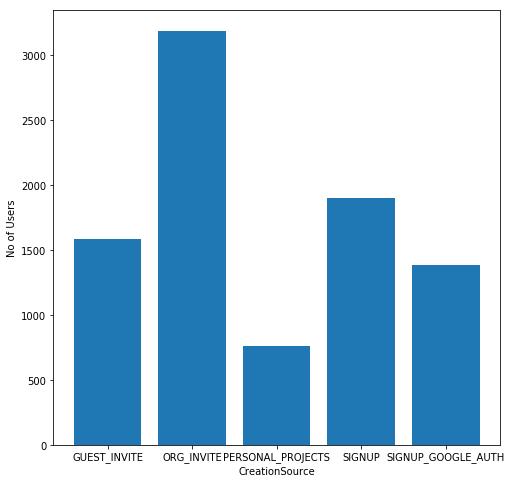

In [58]:
df_c = dfu['creation_source'].groupby(dfu['creation_source']).agg('count')
df_c = pd.DataFrame(df_c)

df_c.columns = ['Noofusers']

dd = df_c.reset_index(level=0)
dd.columns = ['CreationSource','Noofusers']

plt.figure(1, figsize=(8, 8))
plt.bar(dd['CreationSource'], dd['Noofusers'], data=dd)
plt.xlabel('CreationSource')
plt.ylabel('No of Users')
plt.show()

Most of the invites came from Organization invites

The creation time and last session creation time offered better information by using the 2 variables to calculate how long ago the user registered, so the 2 original variables will be dropped. 

Also, the user id of who invited the user will be converted to a binary value to indicate if the user was invited or not. 

Finally, the user_id will be used as index and not part of the features.

In [59]:
df_features = dfu.drop(columns =['totaldays','creation_time', 'last_session_creation_time', 'invited_by_user_id', 'user_id', 'adopted', 'adoptedn'])

df_label = dfu.loc[:, ['adopted', 'adoptedn']]

lbe = LabelEncoder()

df_features['creation_source'] = lbe.fit_transform(dfu['creation_source'])

df_label['adopted'].value_counts()

False    7167
True     1656
Name: adopted, dtype: int64

In [60]:
df_feature_d = pd.get_dummies(df_features, columns=['creation_source'], drop_first=True)
df_feature_d.shape

(8823, 7)

#### Final list of predictors

In [61]:
df_feature_d.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,invited,creation_source_1,creation_source_2,creation_source_3,creation_source_4
object_id,,,,,,,
1,1,0,1,0,0,0,0
2,0,0,1,1,0,0,0
3,0,0,1,1,0,0,0
4,0,0,1,0,0,0,0
5,0,0,1,0,0,0,0


### Split Data into Training and Test Set and confirm proportions

In [ ]:
dffeature

In [62]:
scaler = StandardScaler()
transform = scaler.fit_transform(df_feature_d)

transform.shape

(8823, 7)

In [63]:
# Split the data into a training and test set.
X = df_feature_d
y = df_label['adoptedn']
xtrain, xtest, ytrain, ytest = train_test_split(X, y,random_state=5)


In [64]:
xtrain1, xtest1, ytrain1, ytest1 = train_test_split(transform, df_label['adoptedn'].values,random_state=5)

### Baseline Model

In [65]:
clf = LogisticRegression()
# Fit the model on the trainng data.
clf.fit(xtrain1, ytrain1)
# Print the accuracy from the testing data.
print(accuracy_score(ytest1, clf.predict(xtest1)))

0.8186763372620127


### Cross Validation with Baseline Model

In [66]:
def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 10
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [67]:
clf = LogisticRegression()
score = cv_score(clf, xtrain1, ytrain1)
print(score)

0.8101958033008669


#### Feature Importance of CV model

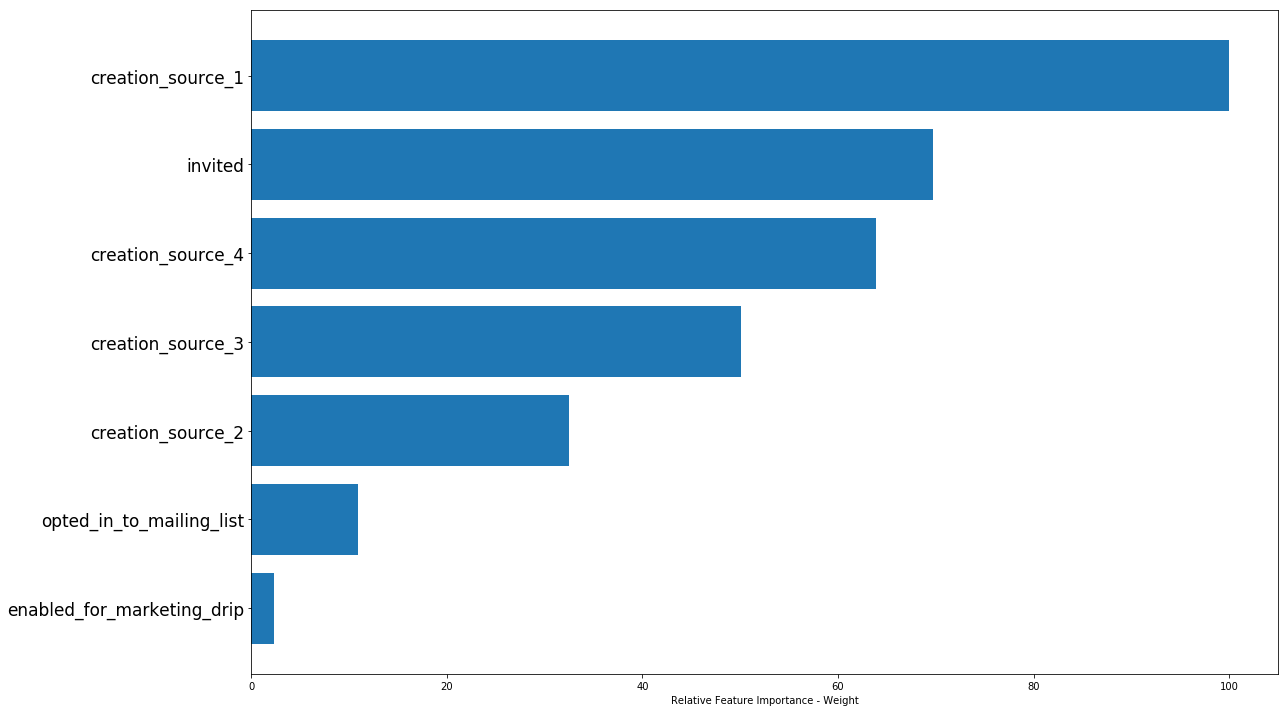

In [68]:
plt.rcParams["figure.figsize"] = (18,10)

feature_importance = abs(clf.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos[-16:][::-1], feature_importance[sorted_idx][-16:][::-1], align='center')
featax.set_yticks(pos[-16:][::-1])
featax.set_yticklabels(np.array(df_feature_d.columns)[sorted_idx][-16:][::-1], fontsize=17)
featax.set_xlabel('Relative Feature Importance - Weight')

plt.tight_layout()   
plt.show()

#### Confusion Matrix of Training set

In [69]:
tn, fp, fn, tp = confusion_matrix(clf.predict(xtrain1), ytrain1).ravel()
(tn, fp, fn, tp)

(5361, 1256, 0, 0)

#### Precision-Recall for training

In [70]:
print(classification_report(ytrain1, clf.predict(xtrain1)))

              precision    recall  f1-score   support

           0       0.81      1.00      0.90      5361
           1       0.00      0.00      0.00      1256

   micro avg       0.81      0.81      0.81      6617
   macro avg       0.41      0.50      0.45      6617
weighted avg       0.66      0.81      0.73      6617



#### ROC Curve Training

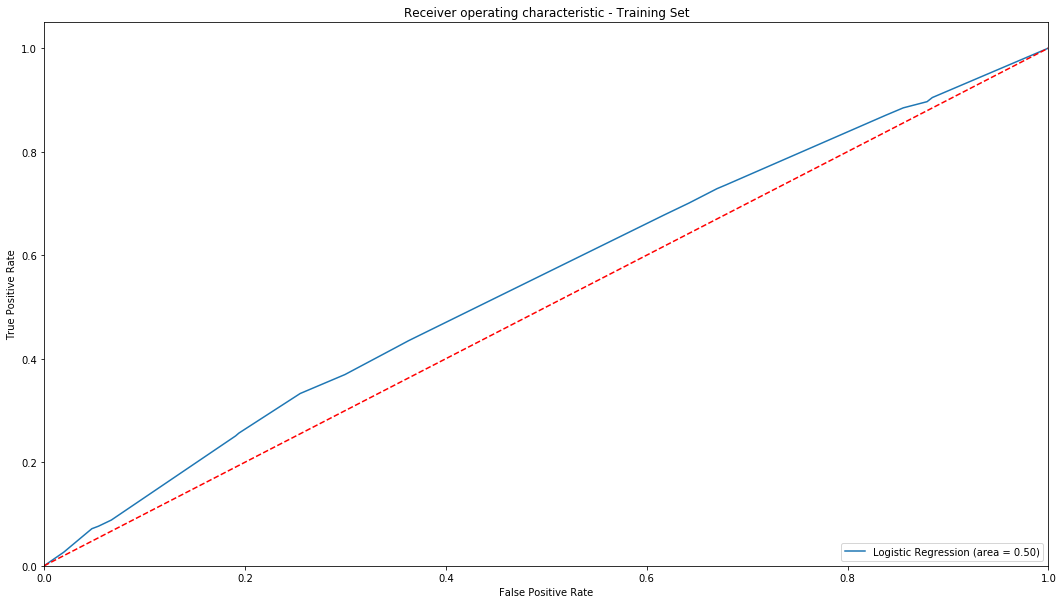

In [71]:
logit_roc_auc = roc_auc_score(ytrain1, clf.predict(xtrain1))
fpr, tpr, thresholds = roc_curve(ytrain1, clf.predict_proba(xtrain1)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - Training Set')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

#### Confusion Matrix of Test set

In [72]:
tn, fp, fn, tp = confusion_matrix(clf.predict(xtest1), ytest1).ravel()
(tn, fp, fn, tp)

(1806, 400, 0, 0)

In [73]:
print(classification_report(ytest1, clf.predict(xtest1)))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90      1806
           1       0.00      0.00      0.00       400

   micro avg       0.82      0.82      0.82      2206
   macro avg       0.41      0.50      0.45      2206
weighted avg       0.67      0.82      0.74      2206



#### ROC Curve Test set

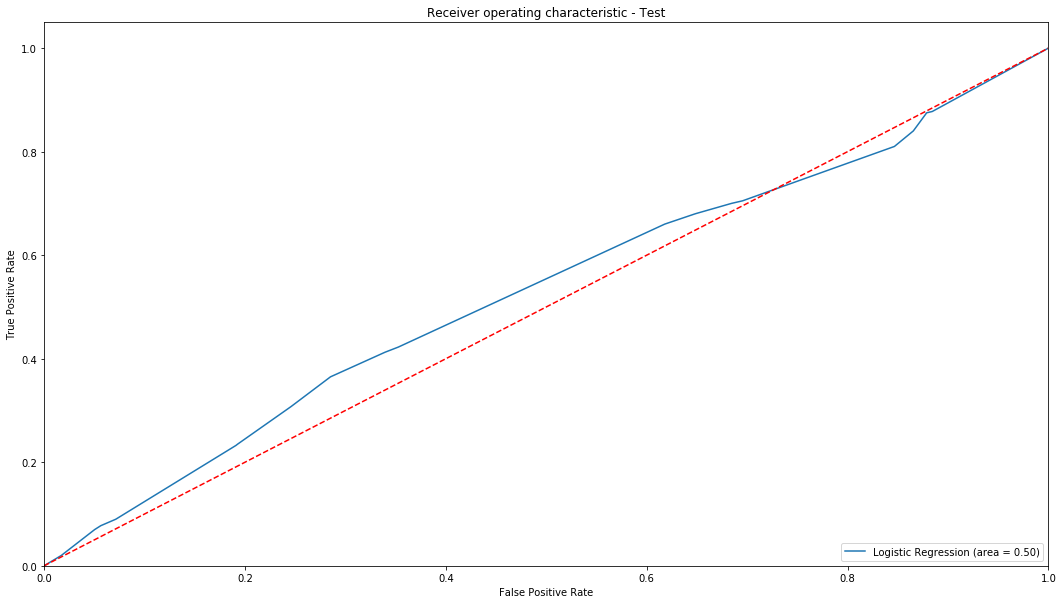

In [74]:

logit_roc_auc = roc_auc_score(ytest1, clf.predict(xtest1))
fpr, tpr, thresholds = roc_curve(ytest1, clf.predict_proba(xtest1)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - Test')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

def get_rolling_count(grp, freq):
    return grp.rolling(freq, on='time_stamp')['user_id'].count()

engage['visits_7_days'] = engage.groupby('user_id', as_index=False, group_keys=False).apply(get_rolling_count, '7D')

##### https://github.com/naveenrc/RelaxChallenge/blob/master/RelaxChallenge.ipynb

def find_adopted_users(x):
    """
    Takes property object x
    converts x to list
    returns 1 if a user logged into the product on three separate
    days in at least one seven day period 
    """
    user_history = [i for i in x]  # convert property object to list
    user_history.sort()  # sort the dates in increasing order
    user_history = [user_history[i+1] - user_history[i] for i in range(len(user_history)-2)]  # compute cumulative difference of current and next day
    # sum i, i+1, i+2 terms and check if it`s less than 7 which gives if it`s in a seven day period
    user_history = [1 for i in range(len(user_history)-2) if user_history[i] + user_history[i+1] + user_history[i+2] <= timedelta(days=7)]
    # condition to check if there`s a 1 in x, return 1 if true
    if 1 in user_history:
        return 1

df_adopted_users = engagement_gb.agg(find_adopted_users)  # group by user_id and aggregate using custom function
df_adopted_users.fillna(0, inplace=True)  # fill null values with 0
df_adopted_users.columns = ['adopted_user']
df_adopted_users.head()